# Latitude-dependent grey radiation

Here is a quick example of using the `climlab.GreyRadiationModel` with a latitude dimension and seasonally varying insolation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab

In [2]:
np.__version__

'1.9.2'

In [3]:
model = climlab.GreyRadiationModel(num_lev=30, num_lat=90)
print model

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [4]:
print model.lat

[-89. -87. -85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63. -61.
 -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35. -33. -31.
 -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.
   1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.  29.
  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.  57.  59.
  61.  63.  65.  67.  69.  71.  73.  75.  77.  79.  81.  83.  85.  87.  89.]


In [5]:
insolation = climlab.radiation.insolation.DailyInsolation(domains=model.Ts.domain)

In [6]:
model.add_subprocess('insolation', insolation)

In [7]:
print model

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>



In [8]:
model.step_forward()

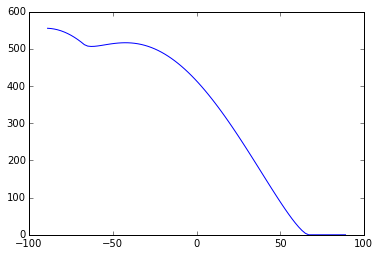

In [9]:
plt.plot(model.lat, model.diagnostics['insolation'])

In [10]:
model.Tatm.shape

(90, 30)

In [11]:
model.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.00207478763 years.


/Users/Brian/climlab/climlab/model/column.py:149: RuntimeWarning: divide by zero encountered in divide
  SW.flux_from_space)


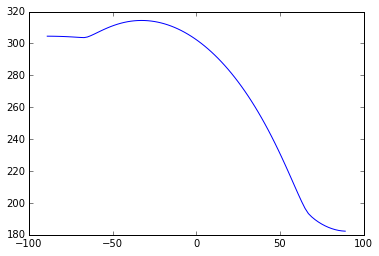

In [12]:
plt.plot(model.lat, model.Ts)

In [13]:
model.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.00141166601 years.


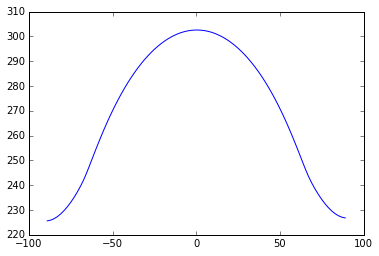

In [14]:
plt.plot(model.lat, model.timeave['Ts'])

In [15]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

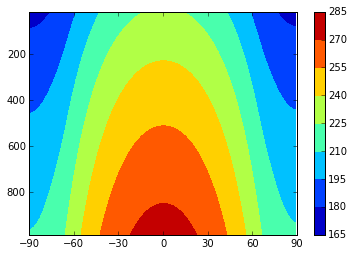

In [16]:
plot_temp_section(model)

In [17]:
model2 = climlab.RadiativeConvectiveModel(num_lev=30, num_lat=90)
insolation = climlab.radiation.insolation.DailyInsolation(domains=model2.Ts.domain)
model2.add_subprocess('insolation', insolation)

In [18]:
model2.step_forward()

In [19]:
model2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.00207478763 years.


In [20]:
model2.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.00141166601 years.


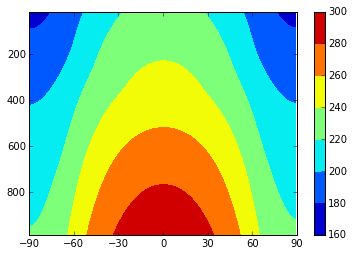

In [21]:
plot_temp_section(model2)

## Testing out multi-dimensional Band Models

In [22]:
import climlab
import numpy as np

#  Put in some ozone
import netCDF4 as nc

datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

# Taking annual, zonal average of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )

In [23]:
import climlab
import numpy as np
#  make a model on the same grid as the ozone
model3 = climlab.BandRCModel(lev=lev, lat=lat)
insolation = climlab.radiation.insolation.DailyInsolation(domains=model3.Ts.domain)
model3.add_subprocess('insolation', insolation)
print model3

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  q: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [24]:
#  Set the ozone mixing ratio
#   IMPORTANT: we need to flip the ozone array around because the vertical coordinate runs the wrong way
#   (first element is top of atmosphere, whereas our model expects the first element to be just above the surface)
O3_trans = np.transpose(O3_zon)
print O3_trans.shape
print lev
print model3.lev


(96, 26)
[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]
[ 992.5561     970.55483    929.648875   867.16076    787.70206    696.79629
  600.5242     510.455255   433.895225   368.81798    313.501265
  266.481155   226.513265   192.539935   163.66207    139.115395
  118.250335   100.514695    85.439115    70.05915     53.114605    37.23029
   23.944625    13.967214     7.3888135    3.544638 ]


In [25]:
print O3_trans[0,:]
O3_flipped = np.fliplr(O3_trans)
print O3_flipped[0,:]

[  6.38942993e-06   5.35192748e-06   4.36139317e-06   3.54215490e-06
   2.93966536e-06   2.40764962e-06   1.87719832e-06   1.47684523e-06
   1.22012045e-06   9.87433395e-07   7.84166275e-07   6.13802627e-07
   4.70927944e-07   3.44805812e-07   2.33233266e-07   1.45751514e-07
   8.87929588e-08   5.73268650e-08   4.14997956e-08   3.36458470e-08
   2.98050260e-08   2.75073511e-08   2.63278590e-08   2.56975987e-08
   2.60181974e-08   2.61373323e-08]
[  2.61373323e-08   2.60181974e-08   2.56975987e-08   2.63278590e-08
   2.75073511e-08   2.98050260e-08   3.36458470e-08   4.14997956e-08
   5.73268650e-08   8.87929588e-08   1.45751514e-07   2.33233266e-07
   3.44805812e-07   4.70927944e-07   6.13802627e-07   7.84166275e-07
   9.87433395e-07   1.22012045e-06   1.47684523e-06   1.87719832e-06
   2.40764962e-06   2.93966536e-06   3.54215490e-06   4.36139317e-06
   5.35192748e-06   6.38942993e-06]


In [26]:
# Put in the ozone
model3.absorber_vmr['O3'] = O3_flipped

In [27]:
print model3.absorber_vmr['O3'].shape
print model3.Tatm.shape

(96, 26)
(96, 26)


In [28]:
model3.step_forward()

In [29]:
model3.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.00207478763 years.


In [30]:
model3.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 2.00141166601 years.


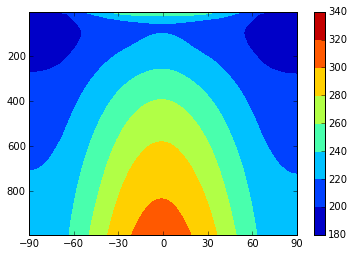

In [31]:
#plt.contour(model3.lat, model3.lev, model3.Tatm.transpose())
plot_temp_section(model3)

This is now working. Will need to do some model tuning.

And start to add dynamics!

In [32]:
testmodel = climlab.BandRCModel(num_lat=90, num_lev=30)

In [33]:
testmodel.step_forward()
testmodel.step_forward()
testmodel.step_forward()

In [34]:
%timeit testmodel.step_forward()

10 loops, best of 3: 25.4 ms per loop


In [35]:
np.__version__

'1.9.2'

Definitely get better performance with numpy version 1.9 and above due to vectorization of `numpy.tril()` (lower triangle operator) for multi-dimensional arrays.

## Experimental...  adding meridional diffusion!

In [36]:
print model2

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [37]:
diffmodel = climlab.process_like(model2)

In [38]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffmodel.Tatm.domain.heat_capacity[0]
print K

1.46414342629e-07


In [39]:
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state=diffmodel.state['Tatm'], **diffmodel.param)

In [40]:
diffmodel.add_subprocess('diffusion', d)

In [41]:
print diffmodel

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Tatm: (90, 30) 
  Ts: (90, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.RadiativeConvectiveModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LW: <class 'climlab.radiation.radiation.Radiation'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.radiation.RadiationSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [42]:
diffmodel.step_forward()

In [43]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.00348645365 years.


In [44]:
diffmodel.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.00282333202 years.


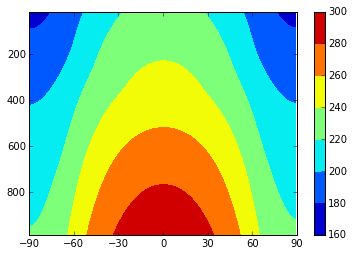

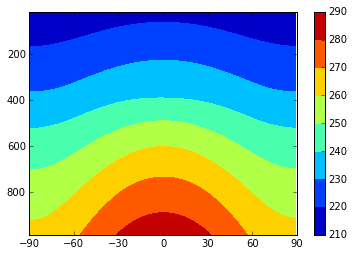

In [45]:
plot_temp_section(model2)
plot_temp_section(diffmodel)

Amazingly... this actually works!

As long as K is a constant.

The diffusion operation is broadcast over all vertical levels without any special code.

In [46]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )


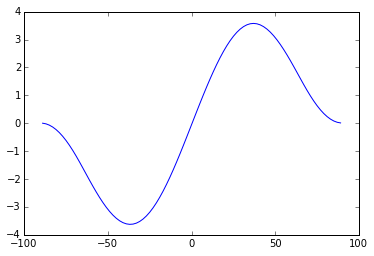

In [47]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffmodel.timeave['ASR'] - diffmodel.timeave['OLR'])
plt.plot(diffmodel.lat, inferred_heat_transport(Rtoa, diffmodel.lat))

### Band model with diffusion

In [48]:
diffband = climlab.process_like(model3)

In [49]:
# thermal diffusivity in W/m**2/degC
D = 0.05
# meridional diffusivity in 1/s
K = D / diffband.Tatm.domain.heat_capacity[0]
print K

2.64602934563e-07


In [50]:
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state=diffband.state['Tatm'], **diffband.param)
diffband.add_subprocess('diffusion', d)
print diffband

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  q: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.DailyInsolation'>



In [51]:
diffband.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.00074854439 years.


In [52]:
diffband.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.00008542277 years.


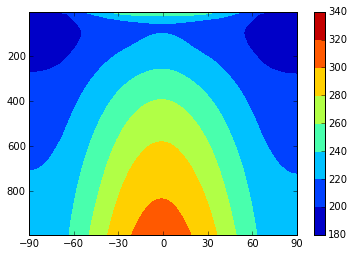

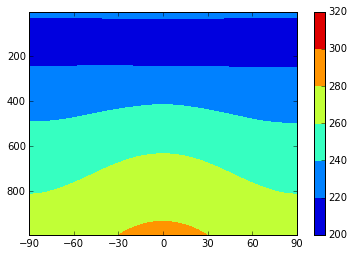

In [53]:
plot_temp_section(model3)
plot_temp_section(diffband)

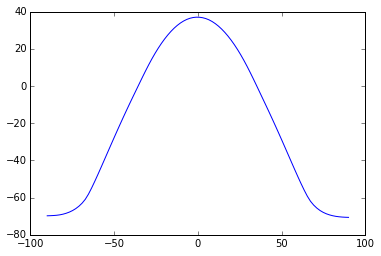

In [54]:
plt.plot(diffband.lat, diffband.timeave['ASR'] - diffband.timeave['OLR'])

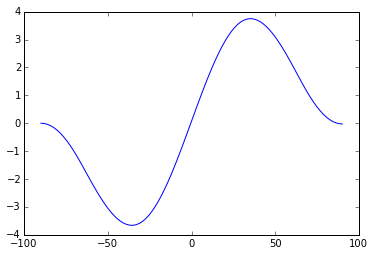

In [55]:
#  Plot the northward heat transport in this model
Rtoa = np.squeeze(diffband.timeave['ASR'] - diffband.timeave['OLR'])
plt.plot(diffband.lat, inferred_heat_transport(Rtoa, diffband.lat))